In [23]:
!pip install newsapi-python google-generativeai

In [ ]:
import pandas as pd
import google.generativeai as genai
import os
import time
import json # Para lidar com JSON na resposta do Gemini

# --- Chaves de API ---
# Sua chave da News API
NEWS_API_KEY = 'a832cf7fe7cf4ab28fae37a4c9a50415'

# Sua chave da Gemini API
# ATENÇÃO: Em um ambiente de produção, é ALTAMENTE recomendado usar variáveis de ambiente
# (e.g., os.getenv("GOOGLE_API_KEY")) para proteger sua chave.
# Coloquei-a diretamente aqui conforme solicitado para fins de demonstração.
GEMINI_API_KEY = 'AGAAIzaSyAfeaqL0jXSs9dQaerTlfdv2yZ0iP38Ak4'

# Configurar a API do Gemini
genai.configure(api_key=GEMINI_API_KEY)
# Usaremos 'gemini-pro' para classificação de texto, pois é o modelo adequado para Python.
model = genai.GenerativeModel('gemini-pro')

# --- Configurações da News API ---
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

# Ajuste nos domínios: remover 'https://' e a barra final se existirem
dominios = "globo.com, folha.uol.com.br, uol.com.br, exame.com, infomoney.com.br, valor.globo.com, braziljournal.com, mckinsey.com.br"

# Categorias de risco e suas palavras-chave (ajustadas para o limite de 500 chars da News API)
queries_por_categoria = {
    "Ambientais_Climaticos": "(('mudanças climáticas' OR 'crise climática' OR 'aquecimento global') AND ('risco' OR 'impacto')) OR 'eventos climáticos extremos' OR 'seca severa' OR 'inundação' OR 'ondas de calor' OR 'incêndios florestais' OR 'perda de biodiversidade' OR 'escassez de água' OR 'poluição' OR 'transição energética' OR 'descarbonização' OR ESG",
    "Geopoliticos_Sociais": "('conflito armado' OR 'tensão geopolítica' OR 'instabilidade política' OR 'guerra comercial' OR 'sanções') OR ('polarização social' OR 'fragmentação social' OR 'desigualdade social') OR ('desinformação' OR 'fake news') OR 'migração em massa' OR 'saúde pública' OR 'pandemia' OR 'segurança alimentar' OR 'protestos'",
    "Tecnologicos": "('inteligência artificial' OR IA OR 'riscos da IA' OR 'IA generativa') AND ('ética' OR 'segurança' OR 'regulamentação' OR 'impacto social' OR 'viés') OR 'cibersegurança' OR 'ataque cibernético' OR 'ransomware' OR 'vazamento de dados' OR 'disrupção digital' OR 'novas tecnologias' OR 'biotecnologia' OR 'computação quântica' OR 'deepfake' OR 'privacidade de dados'",
    "Economicos": "inflação OR recessão OR 'crise econômica' OR 'instabilidade financeira' OR 'dívida pública' OR 'bolha de ativos' OR 'cadeia de suprimentos' OR 'interrupção logística' OR 'escassez de matéria-prima' OR 'desemprego estrutural' OR 'crise de custo de vida' OR 'choque de oferta' OR 'protecionismo econômico'",
    "Governanca_Resiliencia": "'falha de governança' OR 'governança corporativa' OR 'resiliência operacional' OR 'crise de reputação' OR 'conformidade regulatória' OR 'risco ESG' OR 'gestão de crise' OR 'fragilidade institucional' OR 'ameaça iminente' OR 'desafios futuros' OR 'tendências de risco' OR 'crise potencial'"
}

all_articles = []
processed_urls = set()

# --- Coleta de Notícias (News API) ---
print("--- Iniciando Coleta de Notícias ---")
for category, query_str in queries_por_categoria.items():
    print(f"Buscando notícias para a categoria: {category}")

    try:
        response = newsapi.get_everything(
            q=query_str,
            domains=dominios,
            language='pt',
            sort_by='relevancy',
            page_size=100,
            from_param='2025-05-06' # Data atual: 6 de junho de 2025
        )

        if response['status'] == 'ok':
            for article in response['articles']:
                if article['url'] not in processed_urls:
                    article['risk_category_newsapi'] = category
                    all_articles.append(article)
                    processed_urls.add(article['url'])
        else:
            print(f"Erro na requisição para {category}: {response['code']} - {response['message']}")

    except Exception as e:
        print(f"Ocorreu um erro ao buscar notícias para {category}: {e}")

df_noticias = pd.DataFrame(all_articles)
print(f"\nTotal de artigos únicos coletados pela News API: {len(df_noticias)}")

if df_noticias.empty:
    print("Nenhum artigo coletado. Não há dados para classificar com Gemini.")
else:
    # Adiciona uma coluna 'id' temporária para facilitar a referência na resposta do Gemini
    df_noticias['temp_id'] = range(len(df_noticias))
    print("\nDataFrame antes da classificação com Gemini:")
    print(df_noticias[['title', 'source', 'description', 'risk_category_newsapi']].head())

    # --- Classificação com Gemini API (Otimizada por Lote) ---
    print("\n--- Iniciando Classificação com Gemini API (Otimizada por Lote) ---")

    risk_categories_gemini = [
        "Tecnológico",
        "Ambiental/Climático",
        "Geopolítico/Social",
        "Econômico",
        "Governança/Resiliência",
        "Outros/Indefinido"
    ]

    # Ajuste o tamanho do lote conforme a quantidade de texto das descrições e o limite de tokens do Gemini.
    # Um valor entre 5 e 10 é um bom ponto de partida. Teste para ver o ideal.
    BATCH_SIZE = 7 # Número de descrições a serem classificadas por requisição Gemini
    df_noticias['gemini_classification'] = None

    for i in range(0, len(df_noticias), BATCH_SIZE):
        batch_df = df_noticias.iloc[i : i + BATCH_SIZE]
        descriptions_to_classify = []

        # Prepara as descrições para o prompt em lote
        for idx_df, row in batch_df.iterrows():
            if pd.notna(row['description']) and row['description'].strip():
                # Inclui o temp_id para mapear a resposta do Gemini de volta ao DataFrame
                descriptions_to_classify.append(f"ID_{row['temp_id']}:: {row['description']}")
            else:
                df_noticias.at[idx_df, 'gemini_classification'] = "Sem Descrição"

        if not descriptions_to_classify:
            print(f"Lote {i}-{i+BATCH_SIZE-1}: Nenhuma descrição válida para classificar.")
            continue

        # Constrói o prompt para o lote
        prompt_content = "\n".join(descriptions_to_classify)
        prompt = f"""
        Classifique as seguintes descrições de notícias em UMA das categorias de risco.
        Retorne um array JSON, onde cada objeto tem o "id" da notícia e sua "classification".
        Use o formato "ID_<número>" para o id, como visto na entrada.
        Se uma descrição não se encaixar claramente em nenhuma categoria, use 'Outros/Indefinido'.

        Categorias de Risco:
        - Tecnológico
        - Ambiental/Climático
        - Geopolítico/Social
        - Econômico
        - Governança/Resiliência

        Formato de Saída JSON:
        [
            {{"id": "ID_<número>", "classification": "<Categoria>"}},
            ...
        ]

        Descrições das Notícias:
        {prompt_content}
        """

        try:
            response = model.generate_content(prompt)
            classification_text = response.text.strip()

            # Limpa qualquer formatação extra que o Gemini possa adicionar (ex: ```json)
            if classification_text.startswith("```json"):
                classification_text = classification_text[len("```json"):].strip()
            if classification_text.endswith("```"):
                classification_text = classification_text[:-len("```")].strip()

            # Tenta analisar a resposta como JSON
            batch_classifications = json.loads(classification_text)

            for item in batch_classifications:
                original_id_str = item.get('id')
                classification = item.get('classification')

                if original_id_str and classification is not None:
                    # Extrai o número do ID (e.g., de "ID_123" para 123)
                    if original_id_str.startswith("ID_"):
                        original_id = int(original_id_str.split('_')[1])
                    else:
                        print(f"Aviso: ID não no formato esperado '{original_id_str}'. Pulando item: {item}")
                        continue

                    # Atualiza o DataFrame com a classificação do Gemini
                    if original_id < len(df_noticias) and df_noticias.loc[original_id, 'temp_id'] == original_id:
                        if classification in risk_categories_gemini:
                            df_noticias.at[original_id, 'gemini_classification'] = classification
                        else:
                            df_noticias.at[original_id, 'gemini_classification'] = "Outros/Indefinido"
                            print(f"Aviso: Categoria inesperada '{classification}' para ID {original_id}. Marcado como 'Outros/Indefinido'.")
                    else:
                        print(f"Aviso: ID {original_id} da resposta Gemini não corresponde a um índice válido no DataFrame.")
                else:
                    print(f"Aviso: Objeto JSON malformado ou incompleto no lote {i}-{i+BATCH_SIZE-1}: {item}")

        except json.JSONDecodeError as jde:
            print(f"Erro ao decodificar JSON do Gemini no lote {i}-{i+BATCH_SIZE-1}: {jde}")
            print(f"Resposta bruta do Gemini (pode não ser JSON): {classification_text[:500]}...")
            # Marque os artigos deste lote como erro, ou tente reprocessar individualmente
            for idx in indices_in_batch: # assuming indices_in_batch stores the original df indices for the current batch
                 df_noticias.at[idx, 'gemini_classification'] = "Erro JSON"
        except Exception as e:
            print(f"Erro Gemini na classificação do lote {i}-{i+BATCH_SIZE-1}: {e}")
            # Marque os artigos deste lote como erro
            for idx_df_err, row_err in batch_df.iterrows():
                 df_noticias.at[idx_df_err, 'gemini_classification'] = "Erro de Classificação"

        # Pausa para gerenciar limites de taxa da API do Gemini
        # Para 15 RPM, isso significa 1 requisição a cada 4 segundos.
        # Ajuste conforme o seu plano e comportamento da API.
        print(f"Lote {i}-{min(i+BATCH_SIZE-1, len(df_noticias)-1)} processado. Pausando...")
        time.sleep(4.0) # 4.0 segundos de pausa para respeitar 15 RPM

    # Remove a coluna temporária 'temp_id'
    df_noticias = df_noticias.drop(columns=['temp_id'])

    print("\n--- Classificação com Gemini Concluída ---")
    print("\nDataFrame com classificação Gemini:")
    print(df_noticias[['title', 'description', 'risk_category_newsapi', 'gemini_classification']].head(10))

    # Opcional: Salvar o DataFrame resultante em um arquivo CSV
    # df_noticias.to_csv('noticias_classificadas_com_gemini_otimizado.csv', index=False, encoding='utf-8')
    # print("\nResultados salvos em 'noticias_classificadas_com_gemini_otimizado.csv'")

--- Iniciando Coleta de Notícias ---
Buscando notícias para a categoria: Ambientais_Climaticos
Buscando notícias para a categoria: Geopoliticos_Sociais
Buscando notícias para a categoria: Tecnologicos
Buscando notícias para a categoria: Economicos
Buscando notícias para a categoria: Governanca_Resiliencia

Total de artigos únicos coletados pela News API: 257

DataFrame antes da classificação com Gemini:
                                               title  \
0                                               None   
1  “Negação econômica” é risco na luta contra mud...   
2                                               None   
3                                               None   
4            Eduardo Leite defende ‘projeto de país’   

                                      source  \
0         {'id': None, 'name': 'Uol.com.br'}   
1  {'id': 'info-money', 'name': 'InfoMoney'}   
2         {'id': None, 'name': 'Uol.com.br'}   
3         {'id': None, 'name': 'Uol.com.br'}   
4           {'id

In [21]:
df_noticias[df_noticias['risk_category'] == 'Economicos']

,source,author,title,description,url,urlToImage,publishedAt,content,risk_category
199,"{'id': 'globo', 'name': 'Globo'}",None,São Paulo x Buenos Aires: veja qual cidade tem...,"A cesta básica portenha,, estipulada pelo Inde...",https://valor.globo.com/brasil/noticia/2025/05...,https://s2-valor.glbimg.com/RV3W5GuMywk-_LauTB...,2025-05-15T08:01:10Z,Brasileiro reclama que a inflação mensal dos a...,Economicos
200,"{'id': None, 'name': 'Uol.com.br'}",None,None,Agência cita aumento do custo da dívida e lent...,https://www1.folha.uol.com.br/mercado/2025/05/...,https://f.i.uol.com.br/fotografia/2024/10/01/1...,2025-05-30T21:40:45Z,A agência de classificação de risco Moody's Ra...,Economicos
201,"{'id': 'globo', 'name': 'Globo'}",None,Commodities em baixa e real mais forte turvam ...,Analistas projetam desaceleração em bens indus...,https://valor.globo.com/brasil/noticia/2025/05...,https://s2-valor.glbimg.com/Y0pnsHvPzCInx_LiVz...,2025-05-15T08:01:05Z,O cenário de inflação no Brasil em 2025 segue ...,Economicos
202,"{'id': None, 'name': 'Uol.com.br'}",None,None,"Com apoio estatal bilionário, startups desenvo...",https://www1.folha.uol.com.br/mercado/2025/05/...,https://f.i.uol.com.br/fotografia/2025/05/15/1...,2025-05-16T10:53:12Z,"Em um amplo armazém nos subúrbios de Xangai, d...",Economicos
203,"{'id': 'globo', 'name': 'Globo'}",None,País se prepara para segunda onda na transição...,"Luciana Costa, do BNDES, enfatizou necessidade...",https://valor.globo.com/brasil/summit-brazil-u...,https://s2-valor.glbimg.com/EGp31KgsH8MnUAiGWW...,2025-05-15T08:00:31Z,"A diretora de infraestrutura, transição energé...",Economicos
204,"{'id': 'info-money', 'name': 'InfoMoney'}",leonardogstos,Dados econômicos da semana mostrarão resposta ...,Além de números importantes das maiores econom...,https://www.infomoney.com.br/economia/dados-ec...,https://www.infomoney.com.br/wp-content/upload...,2025-05-18T15:03:33Z,Os indicadores divulgados nesta semana podem f...,Economicos
205,"{'id': 'info-money', 'name': 'InfoMoney'}",Carolina Freitas,"De saída do PSDB, Eduardo Leite mira candidatu...","Ao programa InfoMoney Entrevista, o governador...",https://www.infomoney.com.br/politica/de-saida...,https://www.infomoney.com.br/wp-content/upload...,2025-05-08T09:00:00Z,"O governador do Rio Grande do Sul, Eduardo Lei...",Economicos
206,"{'id': 'info-money', 'name': 'InfoMoney'}",Mariana Amaro,Perdemos chance de baratear crédito na Reforma...,"Ao InfoMoney Entrevista, Isaac Sidney, preside...",https://www.infomoney.com.br/economia/perdemos...,https://www.infomoney.com.br/wp-content/upload...,2025-05-21T08:00:00Z,A Reforma Tributária sancionada no começo de 2...,Economicos
207,"{'id': 'info-money', 'name': 'InfoMoney'}",murilomelo,Rebaixamento dos EUA pela Moody’s é alerta pol...,"Para analistas do Bank of America, decisão da ...",https://www.infomoney.com.br/mercados/rebaixam...,https://www.infomoney.com.br/wp-content/upload...,2025-05-19T20:44:25Z,A decisão da Moodys de rebaixar nota de crédit...,Economicos
208,"{'id': 'info-money', 'name': 'InfoMoney'}",Anna França,Juro alto deixa comprador de imóvel mais caute...,"Com a taxa básica de juros em 14,75%, consumid...",https://www.infomoney.com.br/minhas-financas/j...,https://www.infomoney.com.br/wp-content/upload...,2025-05-12T08:00:00Z,"O aumento da taxa Selic para 14,75% pelo Banco...",Economicos


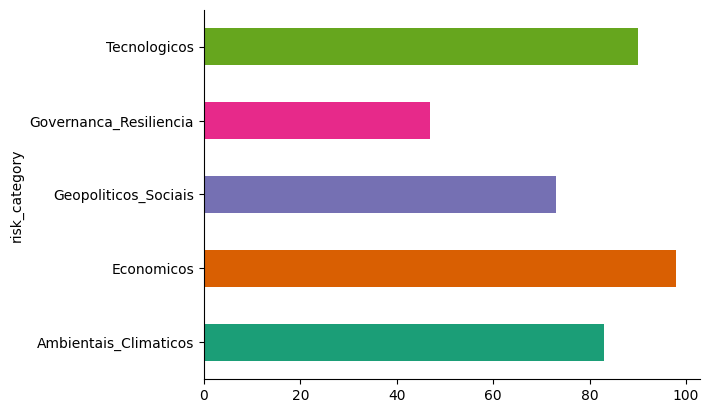

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('risk_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
sources = newsapi.get_sources(language='en', country='us') # Exemplo: apenas fontes em português do Brasil

print("Fontes de notícias em português do Brasil:")
for source in sources['sources']:
    print(f"- {source['name']} (ID: {source['id']})")

Fontes de notícias em português do Brasil:
- ABC News (ID: abc-news)
- Al Jazeera English (ID: al-jazeera-english)
- Ars Technica (ID: ars-technica)
- Associated Press (ID: associated-press)
- Axios (ID: axios)
- Bleacher Report (ID: bleacher-report)
- Bloomberg (ID: bloomberg)
- Breitbart News (ID: breitbart-news)
- Business Insider (ID: business-insider)
- Buzzfeed (ID: buzzfeed)
- CBS News (ID: cbs-news)
- CNN (ID: cnn)
- Crypto Coins News (ID: crypto-coins-news)
- Engadget (ID: engadget)
- Entertainment Weekly (ID: entertainment-weekly)
- ESPN (ID: espn)
- ESPN Cric Info (ID: espn-cric-info)
- Fortune (ID: fortune)
- Fox News (ID: fox-news)
- Fox Sports (ID: fox-sports)
- Google News (ID: google-news)
- Hacker News (ID: hacker-news)
- IGN (ID: ign)
- Mashable (ID: mashable)
- Medical News Today (ID: medical-news-today)
- MSNBC (ID: msnbc)
- MTV News (ID: mtv-news)
- National Geographic (ID: national-geographic)
- National Review (ID: national-review)
- NBC News (ID: nbc-news)
- New